In [ ]:
# Run if using on google collab, change path accordingly
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/[02] School/[01] University/[02] Bachelor\'s Year 2/[02] Spring Semester/[04] Machine Learning/Colab Notebooks/ML - LGI/mlproj/'

In [1]:
# run if running locally
path = ''

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import multiprocessing

cpuc = multiprocessing.cpu_count()-1

#setting seaborn visual style in plt
sns.set_theme()

# Integration & Exploration

In [4]:
traindata: pd.DataFrame = pd.read_csv(path + 'data/train.csv').set_index('Userid')
print(f"Duplicaded: {traindata.duplicated().sum()}\nMissing: {traindata.isna().sum().sum()}\nNon-Registered (empty): {(traindata["Registered"] != "Yes").sum()}")

Duplicaded: 1645
Missing: 10469
Non-Registered (empty): 100


In [ ]:
# import the data and drop remove useless stuff
traindata: pd.DataFrame = traindata.drop('Observations', axis=1).drop_duplicates()
testdata: pd.DataFrame = pd.read_csv(path + 'project_data/test.csv').set_index('Userid').drop(['Registered', 'Observations'], axis=1)

traindata = traindata[traindata['Registered'] == 'Yes']
traindata = traindata.drop('Registered', axis=1)

In [5]:
metricFeatures: list[str] = ['Application order','Previous qualification score','Entry score','Age at enrollment','N units credited 1st period',
       'N units taken 1st period', 'N scored units 1st period',
       'N units approved 1st period', 'Average grade 1st period',
       'N unscored units 1st period', 'N units credited 2nd period',
       'N units taken 2nd period', 'N scored units 2nd period',
       'N units approved 2nd period', 'Average grade 2nd period',
       'N unscored units 2nd period','Social Popularity']
categoricalFeatures: list[str] =  ['Application mode','Marital status','Course','Previous qualification','Nationality',"Mother's qualification",
       "Father's qualification","Mother's occupation","Father's occupation"]
boolFeatures: list[str] = ['Morning shift participation','Displaced','Special needs','Debtor','Regularized Fees','Gender_Male','External Funding','International']

In [ ]:
traindata[metricFeatures].describe()

In [ ]:
X: pd.DataFrame = traindata.drop(['Success'], axis = 1)
y: pd.Series = traindata['Success']

In [ ]:
for variable in categoricalFeatures:
  print(X[variable].value_counts())

ValueError: cannot reindex on an axis with duplicate labels

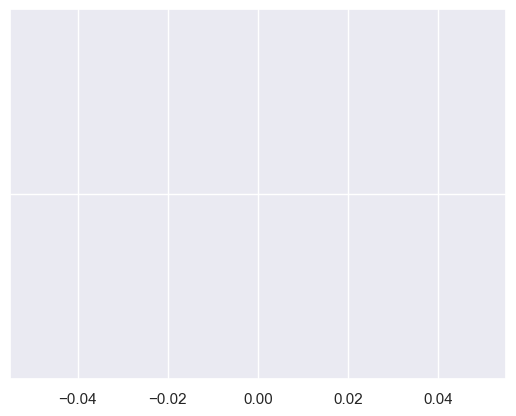

In [7]:
for i, col in enumerate(metricFeatures):
  plt.figure(i)
  sns.boxplot(x=col, data=traindata)

# Preprocessing

In [ ]:
def fillNa(data: pd.DataFrame) -> pd.DataFrame:
    """Fill missing values

    Args:
        data (`pd.DataFrame`): Dataframe to be treated

    Returns:
        `pd.DataFrame`: Treated dataframe
    """    

    # on all of these features, if a value were to be different than 0, then it would not be missing, eg units approved, if the student approved, the value wouldn't be missing
    ifNaThen0: tuple[str,...] = (
        "N units credited 1st period",
        "N unscored units 1st period",
        "N units approved 1st period",
        "N units credited 2nd period",
        "N unscored units 2nd period",
        "N units approved 2nd period"
    )

    # these features are filled differently, basically incoherence checking, but filling the Na on 'N units approved 1st/2nd period' is needed beforehand, more info below
    checkAfterVars: list[list[str,str]] = [
        ["N units taken 1st period", "N units approved 1st period"],
        ["N units taken 2nd period", "N units approved 2nd period"]
    ] 

    for var in metricFeatures:
        if var == (checkAfterVars[0][0] or checkAfterVars[1][0]): 
            continue # skip current iteration
        if var in ifNaThen0:
            data[var] = data[var].fillna(0) # fill the ifNaThen0 vars with well, 0s
        else:    
            data[var] = data[var].fillna(data[var].median()) # fill everything else with the median of the values of the feature

    # here we use the n units taken features we skipped earlier, a student has to have taken at least the same number of courses as the number of courses they passed
    for varList in checkAfterVars:
        # search for Na values on N units taken and replace by the equivalent value on N units approved
        data.loc[data[varList[0]].isna(), varList[0]] = data[varList[1]]
        # search for values on N units taken that are smaller than the equivalent on N units approved, replace by the equivalent value on N units approved
        data.loc[data[varList[0]] < data[varList[1]], varList[0]] = data[varList[1]]

    for var in boolFeatures:
        if var == "Regularized Fees":
            data[var] = data[var].fillna(1) # if nothing is said about the fees, we can assume they have been paid
        else:
            data[var] = data[var].fillna(0) # here is like the ifNaThen0 situation, if the values were to not be 0, they would have been declared

    return data

In [ ]:
def removeOutliers(dataX: pd.DataFrame, datay: pd.DataFrame) -> pd.DataFrame:
    """Removes outliers and fixes any negative number incoherences on the selected variables from the dataframe

    Args:
        data (`pd.DataFrame`): Dataframe to be treated

    Returns:
        `pd.DataFrame`: Treated dataframe
    """    

    toBeTreated: dict[str, dict[str, float | None]] = {
        "Application order": {"lower": 0, "upper": None},
        "Previous qualification score": {"lower": 0, "upper": None},
        "Entry score": {"lower": 0, "upper": None},
        "Age at enrollment": {"lower": 0, "upper": None},
        "N units credited 1st period": {"lower": 0, "upper": 15},
        "N units taken 1st period": {"lower": 0, "upper": 20},
        "N scored units 1st period": {"lower": 0, "upper": 25},
        "N units approved 1st period": {"lower": 0, "upper": 20},
        "Average grade 1st period": {"lower": 0, "upper": None},
        "N unscored units 1st period": {"lower": 0, "upper": None},
        "N units credited 2nd period": {"lower": 0, "upper": 14},
        "N units taken 2nd period": {"lower": 0, "upper": 15},
        "N scored units 2nd period": {"lower": 0, "upper": 25},
        "N units approved 2nd period": {"lower": 0, "upper": 15},
        "Average grade 2nd period": {"lower": 0, "upper": None},
        "N unscored units 2nd period": {"lower": 0, "upper": None},
        "Social Popularity": {"lower": 0, "upper": None},
    }
    
    for var in toBeTreated:
        if toBeTreated[var]["lower"] != None:
            toRemove: list = list(dataX.loc[dataX[var] < toBeTreated[var]["lower"], var].index)
        if toBeTreated[var]["upper"] != None:
            toRemove.extend(list(dataX.loc[dataX[var] > toBeTreated[var]["upper"], var].index))
        dataX.drop(toRemove, axis=0, inplace=True)
        datay.drop(toRemove, axis=0, inplace=True)

    return dataX, datay

In [ ]:
def groupValues(data: pd.DataFrame) -> pd.DataFrame:
    """replace values on columns that have lots of different values that can be grouped together to reduce the total number of dummies created after

    Args:
        data (`pd.DataFrame`): Dataframe to be treated

    Returns:
        `pd.DataFrame`: Treated dataframe
    """    
    
    for col in ["Mother's qualification",  "Father's qualification", "Previous qualification"]:
        data.replace(regex={col: {r"(?i)^no school.*$": '0',
                            r"(?i)^[0-4][a-z]{2} grade.*$": '1', 
                            r"(?i)^[5-9]th grade.*$": '2', 
                            r"(?i)^1[0-2]th grade.*$": '3', 
                            r"(?i)^incomplete bachelor.*$": '4', 
                            r"(?i)^bachelor degree.*$": '5',
                            r"(?i)^post-grad.*$": '6',
                            r"(?i)^master degree.*$": '7',
                            r"(?i)^phd.*$": '8',}}, inplace=True)
    
    for col in ["Mother's occupation", "Father's occupation"]:
        data.replace(to_replace={col: ["Superior-level Professional", "Intermediate-level Professional", "Politician/CEO", "Teacher", "Information Technology Specialist"]}, value="Professional Fields", inplace=True)
        data.replace(to_replace={col: ["Skilled construction workers", "Assembly Worker", "Factory worker", "Lab Technocian"]}, value="Technical and Skilled Trades", inplace=True)
        data.replace(to_replace={col: ["Administrative Staff", "Office worker", "Accounting operator"]}, value="White collar Jobs", inplace=True)
        data.replace(to_replace={col: ["Restaurant worker", "Personal care worker", "Seller", "Cleaning worker"]}, value="Service Industry", inplace=True)
        data.replace(to_replace={col: ["Private Security", "Armed Forces"]}, value="Security and Armed Forces", inplace=True)
        data.replace(to_replace={col: ["Unskilled Worker", "Other", "Student", "Artist"]}, value="Recreational or unskilled", inplace=True)
        data.replace(to_replace={col: ["Engineer", "Scientist", "Health professional"]}, value="STEM Jobs", inplace=True)

    data.replace(to_replace={"Marital status": {"facto union": "married",
                                "legally separated": "divorced",
                                # "widower": "single" reduces performance
                                }}, inplace=True)
    
    return data

In [ ]:
def getDummies(train: pd.DataFrame, test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """get dummies, add 0s to columns that are in test but not in train, and vice-versa, reorder the columns so that they are in the same order

    Args:
        train (`pd.DataFrame`): Train dataframe to be treated
        test (`pd.DataFrame`): Test dataframe to be treated

    Returns:
        `tuple`[`pd.DataFrame`, `pd.DataFrame`]: treated train and test dataframes
    """    
    
    train: pd.DataFrame = pd.get_dummies(data=train, prefix_sep="-", dummy_na=True, drop_first=False)
    test: pd.DataFrame = pd.get_dummies(data=test, prefix_sep="-", dummy_na=True, drop_first=False)

    train[(list(set(test.columns) - set(train.columns)))] = 0
    test[(list(set(train.columns) - set(test.columns)))] = 0

    test = test.reindex(columns=train.columns)

    return train, test

In [ ]:
def scaleData(train: pd.DataFrame, test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Tranforms the values in the dataframes to fit in a scale of 0 to 1

    Args:
        train (pd.DataFrame): Unscaled train dataframe
        test (pd.DataFrame): Unscaled test dataframe

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: Both scaled dataframes
    """    

    scaler = MinMaxScaler()
    scaler.fit(train)

    train = pd.DataFrame(scaler.transform(train), columns = train.columns, index = train.index)
    test = pd.DataFrame(scaler.transform(test), columns = test.columns, index = test.index)

    return train, test

In [ ]:
def prepData(X_train: pd.DataFrame, Y_train: pd.DataFrame, X_test: pd.DataFrame, Y_test: pd.DataFrame | None = None) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame | None]:
    """Runs the preprocessing steps on the dataframes

    Args:
        X_train (pd.DataFrame): Un-preprocessed X_train dataframe
        Y_train (pd.DataFrame): Un-preprocessed Y_train dataframe
        X_test (pd.DataFrame): Un-preprocessed X_test dataframe
        Y_test (pd.DataFrame | None, optional): Un-preprocessed Y_test dataframe, only needed for model assessment. Defaults to None.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame | None]: Treated dataframes
    """    
    
    fillNa(X_train)
    fillNa(X_test)
    removeOutliers(X_train, Y_train)
    
    if type(Y_test) != type(None):
        removeOutliers(X_test, Y_test)

    groupValues(X_train)
    groupValues(X_test)
    X_train, X_test = getDummies(X_train, X_test)
    # X_train, X_test = scaleData(X_train,X_test)

    return X_train, Y_train, X_test, Y_test

# Feature Selection

In [ ]:
# # Run a model to get the features with least importance, remove those that are not important
# model: RandomForestClassifier = RandomForestClassifier(970, n_jobs=cpuc)
# model.fit(X_train, y_train)

# predictions = model.predict(testdata)

# droplist = []

# for x, y in zip(list(X.columns), model.feature_importances_):
#     if y*100 == 0:
#         print(f"{x}: {y*100:.2f}")
#         droplist.append(x)

# X_train.drop(droplist, axis=1, inplace=True)
# X_val.drop(droplist, axis=1, inplace=True)
# testdata.drop(droplist, axis=1, inplace=True)

# DROPPING THESE REDUCES MODEL SCORE

# Model

In [ ]:
def runGS(X_train: pd.DataFrame, Y_train: pd.DataFrame) -> dict:
    """Runs a GridSearch with the parameter space defined within the function

    Args:
        X (pd.DataFrame): Preprocessed X_train
        y (pd.DataFrame): Preprocessed X_train

    Returns:
        dict: Best parameters for the model
    """
    
    model = RandomForestClassifier(n_jobs=cpuc)
    model.fit(X_train,Y_train)
    parameter_space: dict[str] = {
        "n_estimators": tuple(range(100,1000,10)),
        "max_depth": [None, *range(10,101,10)],
        "min_samples_split": tuple(range(2,7)),
        "min_samples_leaf": tuple(range(1,6)),
        # "max_features": ["sqrt", "log2"],
        # "ccp_alpha": tuple(map(lambda x: x/100, range(0, 6)))
        }

    gs = GridSearchCV(model, parameter_space, scoring = 'f1_weighted', cv = 10, verbose=1, n_jobs=cpuc)
    gs.fit(X_train,Y_train)

    return(gs.best_params_)

In [ ]:
def runModel(X_train: pd.DataFrame, Y_train: pd.DataFrame, X_test: pd.DataFrame, Y_test: pd.DataFrame | None = None) -> str | np.ndarray:
    """Runs the model to get predictions or a classification report

    Args:
        X_train (pd.DataFrame): X_train dataframe
        Y_train (pd.DataFrame): Y_train dataframe
        X_test (pd.DataFrame): X_test dataframe
        Y_test (pd.DataFrame | None, optional): Y_test dataframe, only needed for model assessment. Defaults to None.

    Returns:
        str: Classification report, used to assess model performance
        np.ndarray: Predictions, used to create the output file to upload to kaggle
    """    
    
    model: RandomForestClassifier = RandomForestClassifier(n_estimators=936, n_jobs=cpuc)
    model.fit(X_train, Y_train)

    predictions = model.predict(X_test)

    if type(Y_test) != type(None):
        predictions = classification_report(Y_test, predictions)
    
    return predictions

In [ ]:
def runAll(X_train: pd.DataFrame, Y_train: pd.DataFrame, X_test: pd.DataFrame, split: bool = False) -> None:
    """Runs the algorithm

    Args:
        X_train (pd.DataFrame): Raw/Un-preprocessed X_train dataframe
        Y_train (pd.DataFrame): Raw/Un-preprocessed Y_train dataframe
        X_test (pd.DataFrame): Raw/Un-preprocessed X_test dataframe
        split (bool, optional): Whether or not to split the dataframes using train_test_split, used for model assessment. Defaults to False.
    """
    
    if split == True:
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
        X_train, Y_train, X_test, Y_test = prepData(X_train, Y_train, X_test, Y_test)
        print(runModel(X_train, Y_train, X_test, Y_test))
    else:
        X_train, Y_train, X_test, Y_test = prepData(X_train, Y_train, X_test)
        predictions = runModel(X_train, Y_train, X_test)
        outputData: pd.DataFrame = pd.DataFrame([X_test.index, predictions]).T
        outputData.columns = ["Userid", "Success"]
        outputData.set_index('Userid').to_csv("./answer.csv")

In [ ]:
runAll(X, y, testdata, split=False)

In [ ]:
# Uncomment if you feel like using your computer as a heater
# runGS((oUse := prepData(X,y,testdata))[0],oUse[1])